In [1]:
import expipe
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tools
from tqdm import tqdm
import copy
import seaborn as sns
from scipy import stats
import datetime as dt
from matplotlib import colors
import datetime as dt
import warnings

%load_ext autoreload
%autoreload 2

#### Params

In [4]:
p_phase = {
   'Criteria_LatentPhase': {
       'min_len': dt.timedelta(days=3),  # minimal length
       'max_time_latent': dt.timedelta(days=90) # maximal length
   },
   'BL_0': {
       'len': dt.timedelta(days=2),
       'color': '#FDE725FF'},
   'BL_1': {
       'len': dt.timedelta(days=3),
       'color': '#C7E020FF'},
   'Latent_0': {
       'len': dt.timedelta(days=3),
       'color': '#8FD744FF'},
   'Latent_1': {
       'len': dt.timedelta(days=3),
       'color': '#75D054FF'},   
   'Latent_2': {
       'len': dt.timedelta(days=3),
       'color': '#47C16EFF'},
   'Chronic_0': {
       'len': dt.timedelta(days=3),
       'color': '#27AD81FF'},
   'Chronic_1': {
       'len': dt.timedelta(days=3),
       'color': '#1F9A8AFF'},
   'Chronic_2': {
       'len': dt.timedelta(days=3),
       'color': '#24868EFF'},
}

p_columnnames = {
    'date': 'Date',
    'pps_stim': 'PPS Stimulation',
    'surgery': 'Surgery'
}
p_dat = {
#    'path_expipe': "/home/epilepsy-data/data/epimirna/",
    'path_expipe': "/home/jovyan/work/data/epimirna/",
    'name_action_epg_phase': 'define_epg_phases',
    }

#### Load data

In [5]:
project = expipe.get_project(p_dat['path_expipe'])

entities = list(project.entities)
actions = project.actions
actions_rec = {k: v for k, v in actions.items() if v.attributes['type'] == 'eeg recording'}

#### Create new action

In [6]:
action = project.require_action(p_dat['name_action_epg_phase'])
action.type = 'action_'+p_dat['name_action_epg_phase']

#### Define EPG phase separately for each animal


In [7]:
ls_epg_phases = []
for idx in tqdm(entities):
    # get correspodning recording action
    action_i = [ac for k, ac in actions_rec.items() if idx in ac.entities]
    assert len(action_i) == 1
    action_i = action_i[0]
    
    # load annotation file
    fname_annot = action_i.data['df_data_annotation']
    path_annot = str(action_i.data_path()) + '/' + fname_annot
    annot_i = tools.load_dict(path_annot)
    
    epg_phases_i = tools.define_epg_phases(
        annot_i,
        p_phase,
        p_columnnames)
    
    # add ID for identification
    epg_phases_i['ID'] = np.unique(annot_i['ID'])[0]
    
    # add descriptor for PPS stimulation
    stim = '_'.join(annot_i[p_columnnames['pps_stim']].dropna().to_list())
    epg_phases_i['pps_stim'] = stim
                            
    ls_epg_phases.append(epg_phases_i)

    
df_epg_phase = pd.DataFrame(ls_epg_phases)
df_epg_phase.set_index('ID', inplace=True)    


100%|███████████████████████████████████████████████████████████████████| 85/85 [01:10<00:00,  1.21it/s]


### Test table EPG phases

In [10]:
dict_phase = copy.deepcopy(p_phase)
del dict_phase['Criteria_LatentPhase']
ls_keys = list(dict_phase.keys())

for i, row_i in df_epg_phase.iterrows():
    
    # make sure phases are as long as they should
    for key, val in dict_phase.items():
        if not pd.isnull(row_i[key+'_stop']):
            delta_t = row_i[key+'_stop'] - row_i[key+'_start']
            
            assert delta_t - p_phase[key]['len'] <= dt.timedelta(minutes=1)
        
    # make sure phases do not overlap    
    for j in range(len(ls_keys)-1):
        phase_j = ls_keys[j]
        phase_j_n = ls_keys[j+1]
        
        if (not pd.isnull(row_i[phase_j + '_stop']) and
            not pd.isnull(row_i[phase_j_n + '_start'])):  
                pass
            #assert row_i[phase_j + '_stop'] < row_i[phase_j_n + '_start']

### Define whether animals developed epilepsy

In [11]:
df_epg_phase['epg'] = np.nan


# mark animals with spontaneous seizures
EPG_true = ~df_epg_phase['latent_stop'].isnull()
df_epg_phase.loc[EPG_true, 'epg'] = True

# mark those with spontaneous seizures

# add time between end of stimulation and end of latent phase
df_epg_phase['max_time_since_stimstart'] = (
    df_epg_phase['recording_last'] - df_epg_phase['stimulation_start'])

EPG_false = (
    (df_epg_phase['latent_stop'].isnull()) &
    (df_epg_phase['max_time_since_stimstart'] > p_phase['Criteria_LatentPhase']['max_time_latent']))
df_epg_phase.loc[EPG_false, 'epg'] = False

### Assign estimated phases for control animals
To allow comparison between animals which develop epilepsy and those who do not, we assign phases latent1->chronic2 for control animals based on average times in epg animals

In [12]:
phases_to_assign =  ['Latent_1', 'Latent_2', 'Chronic_0', 'Chronic_1', 'Chronic_2']

In [13]:
stim_stop = df_epg_phase['stimulation_stop']

dict_phase_start = {}
for phase_i in phases_to_assign:
    # get distances of phase start from animals which developed epilepsy
    d_start = df_epg_phase[df_epg_phase['epg']==True][phase_i + '_start']-stim_stop
    
    # get average phase start
    d_start_mean = d_start.mean()
    dict_phase_start[phase_i] = d_start_mean

In [14]:
# attribute predefined phases to animals without epg
ids = df_epg_phase[df_epg_phase['epg']!=True].index

for idx in ids:
    stim_stop = df_epg_phase.loc[idx]['stimulation_stop']
    for key_i, val_i in dict_phase_start.items():
        len_phase_i = p_phase[key_i]['len']
        
        phase_i_start = stim_stop + val_i
        phase_i_stop = phase_i_start + len_phase_i
        
        # if any recording exists before terminating day, assign phase
        # phases can maximally last until day before perfusion
        rec_last_valid = df_epg_phase.loc[idx]['recording_last']-dt.timedelta(days=1)
        
        if phase_i_start <= rec_last_valid:
            df_epg_phase.loc[idx, key_i+'_start'] = phase_i_start
            phase_i_stop = np.minimum(phase_i_stop, rec_last_valid)
            df_epg_phase.loc[idx, key_i+'_stop'] = phase_i_stop         

#### Store EPG phases

In [15]:
data_path = str(action.data_path())
fname = 'df_epg_phase.pckl'
path_fname_data = data_path + '/' + fname 
tools.save_dict(df_epg_phase, path_fname_data)
action.data[fname] = path_fname_data

### Visualize EPG phases

In [16]:
ls_phase = [
    'BL_0',
    'BL_1',
    'Latent_0',
    'Latent_1',
    'Latent_2',
    'Chronic_0',
    'Chronic_1',
    'Chronic_2']

In [17]:
df_sel = df_epg_phase

dt_surgery = df_sel['surgery']
dt_last = df_sel['recording_last']

#n_days = (dt_last - dt_surgery).max().days
n_days = 120
n_animals = len(df_sel)
ar_phase = np.zeros((n_animals, n_days))
ar_phase[:, :] = np.nan

for i, phase_i in enumerate(ls_phase):
    start_i = (df_sel[phase_i + '_start'] - dt_surgery).dt.days
    stop_i = (df_sel[phase_i + '_stop'] - dt_surgery).dt.days
    for j, idx_j in enumerate(df_sel.index.unique()):
        if ~np.isnan(start_i[idx_j]) and ~np.isnan(stop_i[idx_j]):
            start_ij = int(start_i[idx_j])
            stop_ij = int(stop_i[idx_j])
            ar_phase[j, start_ij:stop_ij+1] = i

[Text(1, 0.5, 'BL_0'),
 Text(1, 1.5, 'BL_1'),
 Text(1, 2.5, 'Latent_0'),
 Text(1, 3.5, 'Latent_1'),
 Text(1, 4.5, 'Latent_2'),
 Text(1, 5.5, 'Chronic_0'),
 Text(1, 6.5, 'Chronic_1'),
 Text(1, 7.5, 'Chronic_2')]

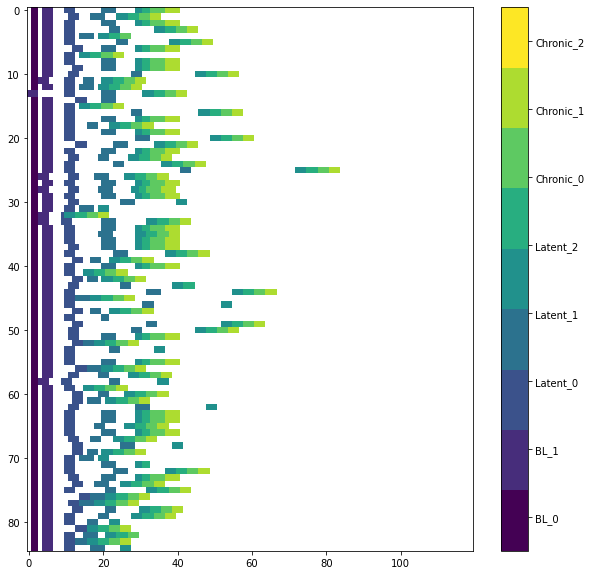

In [18]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

n_phase = len(p_phase)
cmap = plt.get_cmap('viridis', n_phase)

img = ax.imshow(
    ar_phase,
    cmap=cmap,
    interpolation=None,
    vmax=n_phase-1)
ax.set_aspect('auto')

#bounds=np.array([0, 0.001, 0.01, 0.05, 1])
#norm = colors.BoundaryNorm(bounds, cmap.N)
cbar = plt.colorbar(
    img,
#    cmap=cmap,
    #norm=norm,
    #boundaries=bounds,
    #ticks=bounds[1:]/2.
)
cbar.ax.set_yticks(np.arange(0.5, n_phase-1, 1))
cbar.ax.set_yticklabels(ls_phase)
#ax.set_title('p-value - Mann-Whitney-U')
#ax.set_xticks(np.arange(len(ls_phase)))
#ax.set_xticklabels(ls_phase)
#ax.tick_params(axis='x', rotation=45)
#ax.set_yticks(np.arange(len(ls_phase)))
#ax.set_yticklabels(ls_phase)